# Binary Classification using Deep Neural Network with Sigmoid

This notebook is almost similar to the DNN using softmax, the different part is the last dense layer which is the classifier. n this study, we use **sigmoid activation function** and **binary_crossentropy** as loss parameter during compile.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import cv2
import glob
import shutil
from collections import Counter

from keras.callbacks import Callback
from keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

Using TensorFlow backend.


TensorFlow version 2.3.1


In [3]:
# Set up path

base_dir = os.path.join(os.getcwd(), 'cheesecake_vs_friedrice')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
classes = ['cheesecake', 'fried_rice']

for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

cheesecake: 50 Images
fried_rice: 48 Images


In [6]:
batch_size = 10
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 78 images belonging to 2 classes.


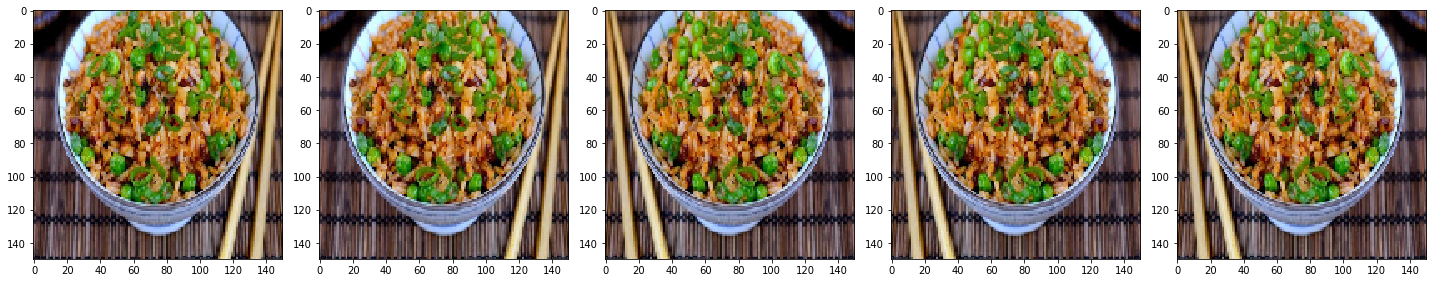

In [8]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[1][0][0] for i in range(5)]
plotImages(augmented_images)

Found 78 images belonging to 2 classes.


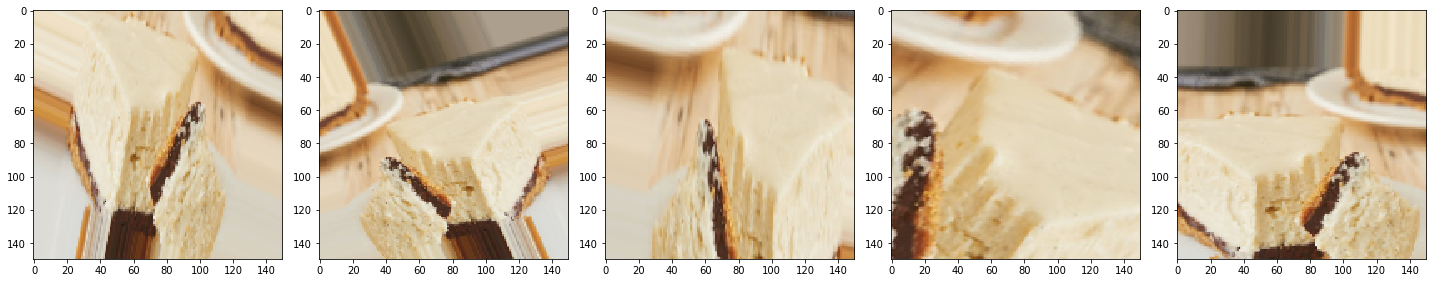

In [9]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [10]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 20 images belonging to 2 classes.


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4320064   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,328,513
Trainable params: 4,328,513
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
8/8 [==============================] - 2s 210ms/step - loss: 5.9677 - accuracy: 0.5128 - val_loss: 1.1256 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 1s 179ms/step - loss: 2.4240 - accuracy: 0.4744 - val_loss: 0.9377 - val_accuracy: 0.7000
Epoch 3/100
8/8 [==============================] - 1s 179ms/step - loss: 1.3463 - accuracy: 0.6410 - val_loss: 2.9178 - val_accuracy: 0.5500
Epoch 4/100
8/8 [==============================] - 1s 181ms/step - loss: 3.3495 - accuracy: 0.5769 - val_loss: 3.5605 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 2s 211ms/step - loss: 2.5993 - accuracy: 0.6154 - val_loss: 1.1068 - val_accuracy: 0.7500
Epoch 6/100
8/8 [==============================] - 1s 180ms/step - loss: 1.0653 - accuracy: 0.7179 - val_loss: 0.7724 - val_accuracy: 0.8000
Epoch 7/100
8/8 [==============================] - 1s 178ms/step - loss: 1.4779 - accuracy: 0.6795 - val_loss: 0.6890 - val_accuracy: 0.7500
Epoch 8/100
8

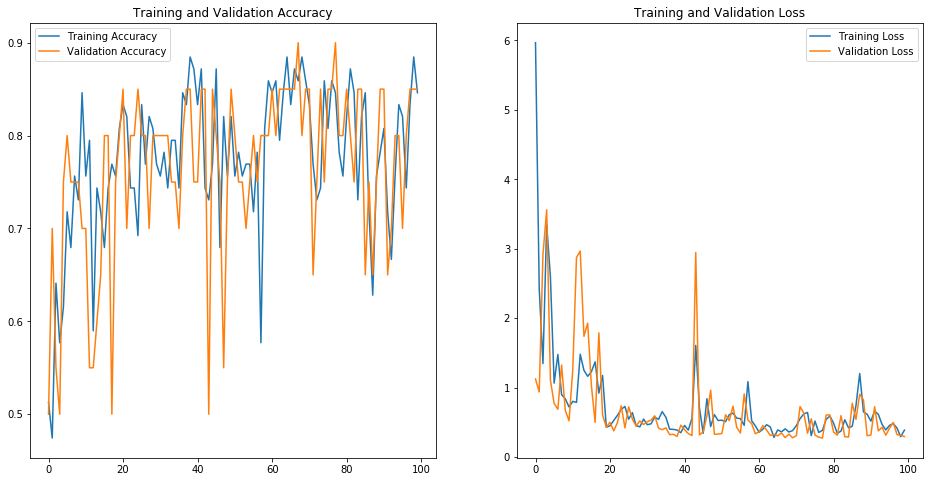

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# read test data
import PIL
import PIL.Image
import pathlib

test_dir = pathlib.Path(test_dir)
image_count = len(list(test_dir.glob('*')))
print('Total test file: ',image_count)

Total test file:  4


In [18]:
def normalize(images):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images

In [43]:
test_image = list(test_dir.glob('*'))

test_array = []
y_pred = []
score_list = []
food_name = []

for test_url in test_image:
    test_img = tf.keras.preprocessing.image.load_img(test_url, target_size=(IMG_SHAPE,IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    norm_img_array = normalize(img_array)
    test_array.append(norm_img_array)
    pred = model.predict(norm_img_array)[0]
    print('Prediction :', pred)
    score = pred
    
    if pred > 0.5:
        output = 'fried_rice'
        food_name.append(output)
        score_list.append(score)
        print("This image most likely belongs to {} with a {:.2f} percent confidence score."
            .format(output, 100 * np.max(score)))
        y_pred.append(1)
    else:
        output = 'cheesecake'
        food_name.append(output)
        score_list.append(1-score)
        print("This image most likely belongs to {} with a {:.2f} percent confidence score."
            .format(output, 100 * (1-np.max(score))))
        y_pred.append(0)

#     print('The actual file name is ', os.path.basename(os.path.normpath(test_url)))

Prediction : [0.37280005]
This image most likely belongs to cheesecake with a 62.72 percent confidence score.
Prediction : [0.0409956]
This image most likely belongs to cheesecake with a 95.90 percent confidence score.
Prediction : [0.38081223]
This image most likely belongs to cheesecake with a 61.92 percent confidence score.
Prediction : [0.94291663]
This image most likely belongs to fried_rice with a 94.29 percent confidence score.


In [44]:
score_list

[array([0.62719995], dtype=float32),
 array([0.9590044], dtype=float32),
 array([0.6191878], dtype=float32),
 array([0.94291663], dtype=float32)]

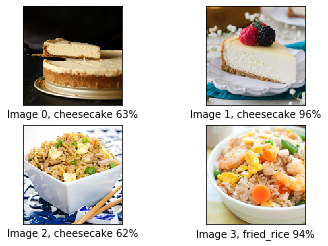

In [45]:
for i in range(len(test_image)):
    predictions_array, img = y_pred[i], test_image[i]

    img = PIL.Image.open(test_image[i])
    img = img.resize((IMG_SHAPE,IMG_SHAPE), PIL.Image.ANTIALIAS)
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(predictions_array)


    plt.xlabel("Image {}, {} {:2.0f}%".format(i, food_name[i],100*np.max(score_list[i])))

In [47]:
from sklearn.metrics import f1_score

# By default, the 0 is represent cheesecake, while 1 represents fried rice
y_true = [0, 0, 1, 1]

micro_f1_score = f1_score(y_true, y_pred, average='micro')
print('F1 score micro is ', micro_f1_score)
macro_f1_score = f1_score(y_true, y_pred, average='macro')
print('F1 score macro is ', macro_f1_score)
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
print('F1 score weighted is ', weighted_f1_score)

F1 score micro is  0.75
F1 score macro is  0.7333333333333334
F1 score weighted is  0.7333333333333334


In [48]:
print('Avg acc      :', np.mean(acc))
print('Avg val_acc  :', np.mean(val_acc))
print('Avg loss     :', np.mean(loss))
print('Avg val_loss :', np.mean(val_loss))

Avg acc      : 0.7752564090490341
Avg val_acc  : 0.7650000077486038
Avg loss     : 0.7350656998157501
Avg val_loss : 0.6768971544504165
